# Wave equation in a slit domain

In the following we will consider the wave equation
\begin{align*}
  \partial_{tt}\psi - \Delta\psi &= 0, && \text{in } \Omega\times(0,T), \\
          \psi &= g, && \text{on } \Gamma_D\times(0,T), \\
     \nabla\psi\cdot n &= 0 && \text{on } \partial\Omega\setminus\Gamma_D,
\end{align*}
where $n$ is the outward unit normal and $g$ is given Dirichlet data
given on part of the domain boundary. We repeat a double slit experiment,
i.e., we have a wave channel which ends in two slits on the right and
forcing the wave on the left end by defining $g=\frac{1}{10\pi}\cos(10\pi t)$.

We discretize the wave equation by an explicit symplectic time stepping
scheme for two unknowns $\psi^n$ and $p^n$ where $p=-\partial_t\psi$ based
on
\begin{align*}
  \partial_t \psi = -p, \\
  \partial_t p    = -\triangle\psi
\end{align*}
The discretization first updates $\psi$ by half a time step then updates
$p$ and concludes by another update step for $\psi$. So given
$(\psi^n,p^n)$ we compute
\begin{align*}
  \psi^{n+\frac{1}{2}} &= \psi^n - \frac{\Delta t}{2}p^n, \\
  p^{n+1}              &=
      \begin{cases}
           p^n - \triangle\psi^{n+\frac{1}{2}} & \text{in the interior}, \\
           g(t^{n+1}) & \text{on }\Gamma_D
      \end{cases} \\
  \psi^{n+1}           &= \psi^{n+\frac{1}{2}} - \frac{\Delta t}{2}p^{n+1}.
\end{align*}
Note that the update for $\psi$ does not involve any spatial derivatives
so can be performed directly on the level of the degree of freedom
vectors. We use *numpy* for these steps. For the update of $p$ we
use a variational formulation
\begin{align*}
  \vec{p} &= \vec{p} + M^{-1}S\vec{\psi}
\end{align*}
where $S$ is the stiffness matrix
$S=(\int_\Omega\nabla\varphi_j\nabla\varphi_i)_{ij}$ and $M$ is the mass
matrix, i.e., $M=\int_\Omega\varphi_j\varphi_i)_{ij}$. To simplify the
computation we use a lumped version of this matrix, i.e,,
$M\approx{\rm diag}(\int_\Omega\varphi_i)$. In this form the algorithm
only involves a matrix vector multiplication and no implicit solving step
is required.

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math
import dune.fem as fem
from dune.grid import reader
from dune.alugrid import aluConformGrid as leafGridView
from dune.fem.space import lagrange as solutionSpace
from ufl import TrialFunction, TestFunction, grad, dot, dx
from dune.ufl import Constant, BoxDirichletBC
fem.parameter.append({"fem.verboserank":-1})
T = 3
dt = 0.005
t = 0

We use *gmsh* to define the domain and then set up a first order
scalar Lagrange space which we will use both for $\psi$ and $p$. We can
construct general grids by either defining the grids directly in Python
(as demonstrated in the following example) or by reading the grid from
files using readers provided by Dune, e.g., Dune Grid Format (dgf) files
or Gmsh files.

In [2]:
domain = (reader.gmsh, "wave_tank.msh")
gridView  = leafGridView( domain, dimgrid=2 )
gridView.hierarchicalGrid.loadBalance()
V = solutionSpace(gridView, order=1, storage="fem")

p      = V.interpolate(0,name="p")
phi    = V.interpolate(0,name="phi")
pVec   = p.as_numpy
phiVec = phi.as_numpy

Next we define an operator for the stiffness matrix including the
boundary condition which are time dependent so we use a `Constant` for
this. We use the `BoxDirichletBC` class which is derived from the more
general `DirichletBC` class which takes a function space, the boundary
function $g$ as a ufl expression, and finally a description of the part
$\Gamma_D$ of the boundary where this boundary condition is defined.
This can be a ufl expression which evaluates to $0$ for
$x\not\in\Gamma_D$, e.g., an ufl `conditional`.

Note that the stiffness matrix does not depend on time so we can
assemble the matrix once and extract the corresponding sscipy*
sparse matrix.

In [3]:
u    = TrialFunction(V)
v    = TestFunction(V)
p_in = Constant(0.0, name="g")
# the following is equivalent to
# x    = SpatialCoordinate(V)
# bc   = DirichletBC(V, p_in, conditional(x[0]<1e-10,1,0))
bc   = BoxDirichletBC(V, p_in, [None,None],[0,None], eps=1e-10)

from dune.fem.operator import galerkin,linear
op        = galerkin([dot(grad(u),grad(v))*dx,bc])
S         = linear(op).as_numpy
lapPhi    = V.interpolate(1,name="e")
lapPhiVec = lapPhi.as_numpy

Next we multiply the inverse lumped mass matrix to $S$, i.e., we form the
matrix $\Delta t M^{-1}S$ where $M$ is a diagonal matrix with entries
$m_{ii} = \int_\Omega\varphi_i$. To compute these values we construct the
mass operator $<L[u],\varphi_i> = \int_\Omega u\varphi_i$ and apply it to
$u\equiv 1$

In [4]:
from scipy.sparse import dia_matrix
lumping = galerkin(u*v*dx)
lumped = lapPhi.copy()
lumping(lapPhi,lumped)       # note that lapPhi=1
N = len(lumped.as_numpy)
M = dia_matrix(([dt/lumped.as_numpy],[0]),shape=(N,N) )
S = M*S

We can now set up the time loop and perform our explicit time stepping
algorithm. Note that the computation is carried out completely using
*numpy* and *scipy* algorithms we the exception of setting the
boundary conditions. This is done using the `setConstraints` method on
the stiffness operator which we constructed passing in the boundary
conditions. At the time of writing it is not yet possible to extract a
sparse matrix and vector encoding the boundary constraint.

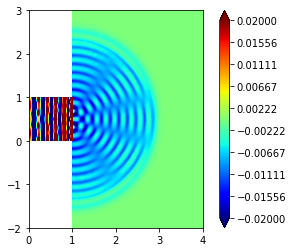

In [5]:
step = 0
while t <= T:
    step += 1
    phiVec[:] -= pVec[:]*dt/2
    pVec[:]   += S*phiVec[:]
    t += dt
    # set the values on the Dirichlet boundary
    op.model.g = math.sin(2*math.pi*5*t)
    op.setConstraints(p)
    phiVec[:] -= pVec[:]*dt/2
phi.plot(gridLines=None, clim=[-0.02,0.02])